# DeepWeeds - Image Classification - Using ResNet50 Model

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import shutil

seed = 999
tf.random.set_seed(seed)

2024-03-05 23:18:07.143545: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 23:18:07.143668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 23:18:07.294028: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [3]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/deepweeds/labels.csv") ## For Kaggle
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [4]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [5]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [6]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

# Splitting Data into Train:Valid:Test Splits (60:40:40)

In [7]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 2 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])
# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break
        
# # trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# # train_data = pd.DataFrame({"Filename":trax,"label":tray})

# # trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# # valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# # test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 3 out of 5 folds
-------------------------------------------------



In [8]:
## Using Folds Used in The DeepWeeds Paper
train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
train_data.rename(columns={"Label":"label"}, inplace=True)

valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  676  638  619  613  637  605  644  610  5464 	Total: (10506, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  212  206  205  213  202  215  203  1821 	Total: (3502, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  212  202  215  203  1821 	Total: (3501, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)

In [9]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)
        
        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [10]:
from sklearn.utils import class_weight

def getWeightedClass(data, power=1, col="Label"):

    class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(data_info[col]),
                                                 y=data_info[col])

    return  { label: pow(class_weights[label],power) for label in range(len(class_weights)) }

getWeightedClass(data_info)

{0: 1.729283950617284,
 1: 1.8284252297410193,
 2: 1.8869490246793836,
 3: 1.9035659926070885,
 4: 1.8318685917555975,
 5: 1.9280916198656535,
 6: 1.8114007862611214,
 7: 1.9148075240594926,
 8: 0.21364423945139957}

In [35]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()
    
    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP
        
        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)
        
        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)
        
        false_rate.append((fP_Rate,accuracy))
    
    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()          
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()      
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()
    
def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model.predict_on_batch(batch[0])))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    
    total_epoch = len(acc)
    if 'peaks' in history:
        peaks = history['peaks']
    else:        
        peaks = [0 if total_epoch<=6 else total_epoch-6]
    
    epochs = range(total_epoch)
    print("Total Epochs:",total_epoch)
    
    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()
      
    plt.show()

# Creating Dateset ImageGenerator

In [12]:
IMG_SIZE=(256,256,3)
oversampling = 1 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/deepweeds/images" ## For Kaggle
base_dir = "/kaggle/working/deepweeds_9c" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

Oversampling 1 times for labels [0 1 7 6 4 3 5 2]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [25]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=32,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

Found 15548 files belonging to 9 classes.
Found 3501 files belonging to 9 classes.
Found 3502 files belonging to 9 classes.


# Displaying Sample Images

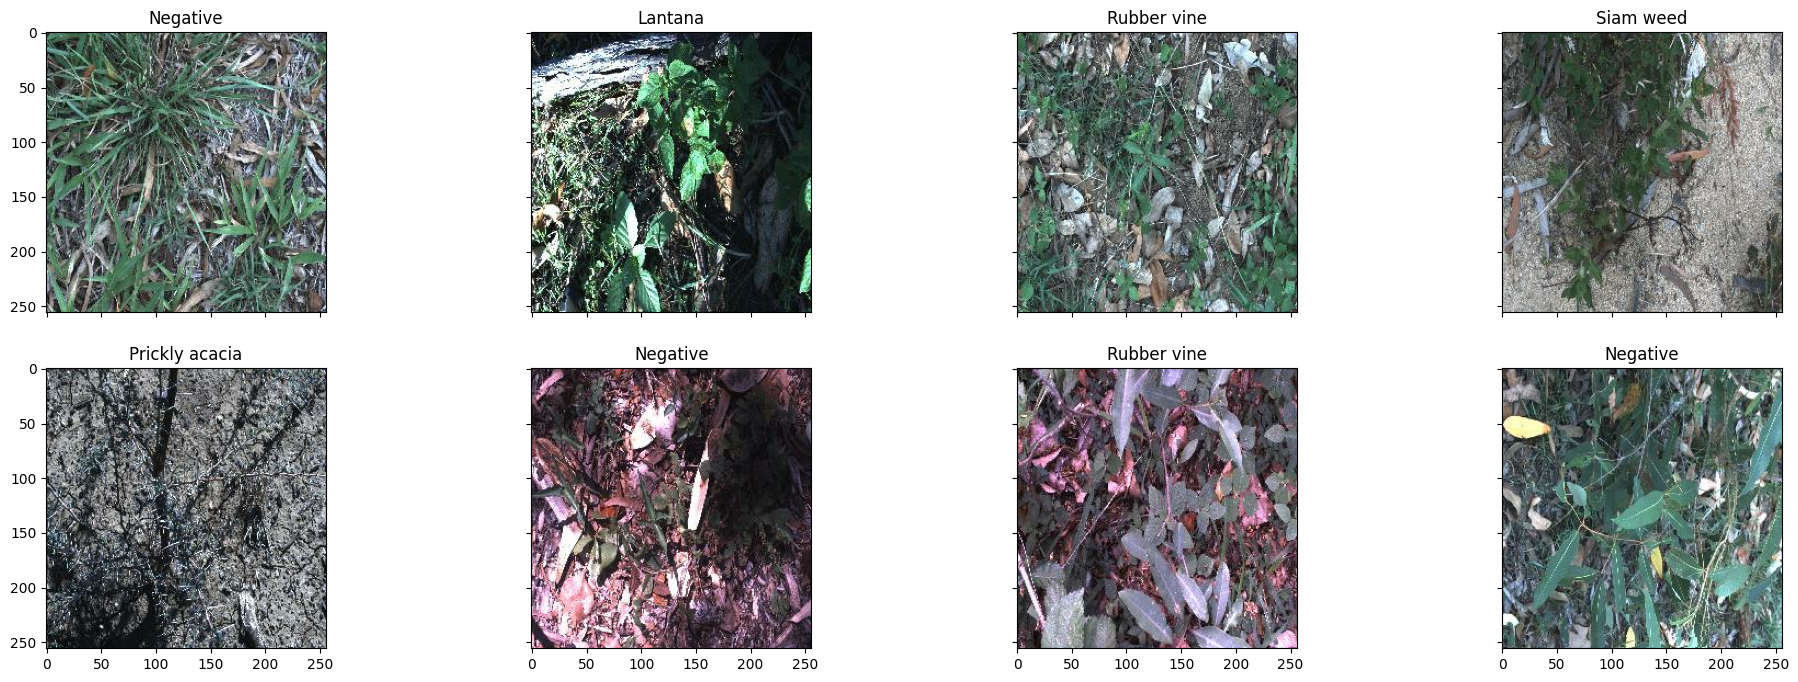

In [26]:
#image visualization

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

# ResNet50

In [27]:
# prompt: code to implement resnet

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.applications import ResNet50V2, resnet_v2

def buildResNetModel(train_resnet=False):
    # Load the ResNet50 model with weights pre-trained on ImageNet.
    base_model = resnet_v2.ResNet50V2(weights='imagenet', include_top=False)
    base_model.trainable = train_resnet
    print("Base Model:", base_model.name)

    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE)

    # Pre-process the input.
    x = layers.Rescaling(1./255)(inputs)
    # x = layers.Resizing(224, 224)(x)
    
    ## DAta Augmentation
    x = layers.RandomBrightness(0.25, (0, 1),seed=seed)(x)
    x = layers.RandomContrast(0.1, seed=seed)(x)
    x = layers.GaussianDropout(0.05, seed=seed)(x)
    x = layers.RandomFlip(seed=seed)(x)
    x = layers.RandomRotation(0.5, seed=seed)(x)
    x = layers.RandomTranslation(0.2, 0.2, seed=seed)(x)
    x = layers.RandomZoom(0.2, 0.2, seed=seed)(x)

    # Pass the input through the pre-trained InceptionV3 model.
    x = base_model(x, training=train_resnet)    
    x = layers.Dropout(0.2)(x) 
    
    ## Add a global average pooling layer.
    x = layers.GlobalAveragePooling2D()(x)
    
    outputs = layers.Dense(9, activation='softmax')(x)

    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name='DeepWeeds-ResNet50')
    return model

In [28]:
model = buildResNetModel(train_resnet=True)
model.summary()

Base Model: resnet50v2
Model: "DeepWeeds-ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_brightness_2 (Rando  (None, 256, 256, 3)       0         
 mBrightness)                                                    
                                                                 
 random_contrast_2 (RandomC  (None, 256, 256, 3)       0         
 ontrast)                                                        
                                                                 
 gaussian_dropout_2 (Gaussi  (None, 256, 256, 3)       0         
 anDropout)                                                      
                         

# Trial 1

In [29]:
from tensorflow.keras.optimizers import RMSprop, AdamW

# Constant for epochs
EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-4,  weight_decay=3e-2),
          metrics=['accuracy'])
# weights = getWeightedClass(data_info, 1/3)
# weights

Epoch 1/100


2024-03-05 23:32:09.823526: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


486/486 [==============================] - 157s 259ms/step - loss: 0.9786 - accuracy: 0.6524 - val_loss: 0.7171 - val_accuracy: 0.7444
Epoch 2/100
486/486 [==============================] - 123s 253ms/step - loss: 0.6542 - accuracy: 0.7690 - val_loss: 0.6113 - val_accuracy: 0.7887
Epoch 3/100
486/486 [==============================] - 123s 253ms/step - loss: 0.5534 - accuracy: 0.8085 - val_loss: 0.5746 - val_accuracy: 0.8044
Epoch 4/100
486/486 [==============================] - 123s 253ms/step - loss: 0.4913 - accuracy: 0.8288 - val_loss: 0.5436 - val_accuracy: 0.8113
Epoch 5/100
486/486 [==============================] - 123s 253ms/step - loss: 0.4447 - accuracy: 0.8431 - val_loss: 0.5134 - val_accuracy: 0.8264
Epoch 6/100
486/486 [==============================] - 123s 253ms/step - loss: 0.4070 - accuracy: 0.8598 - val_loss: 0.4478 - val_accuracy: 0.8469
Epoch 7/100
486/486 [==============================] - 123s 253ms/step - loss: 0.3954 - accuracy: 0.8613 - val_loss: 0.4396 - val_

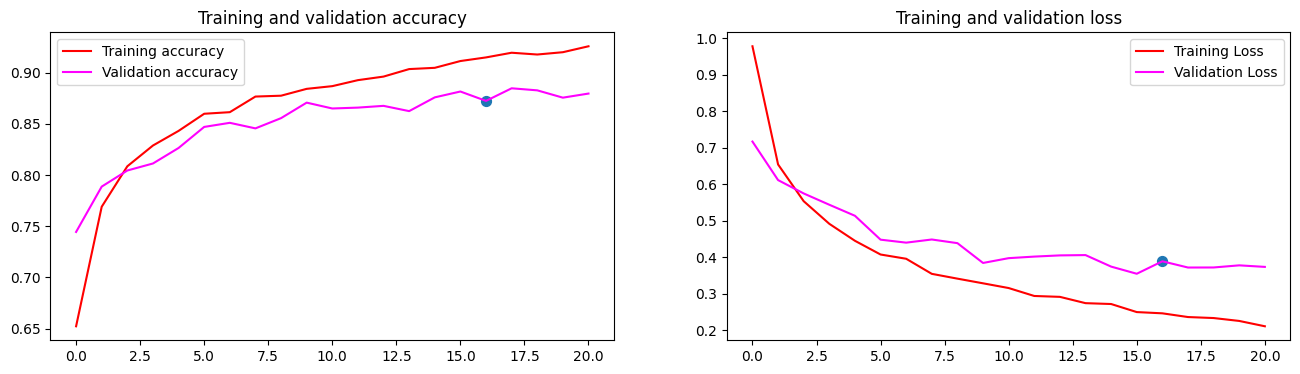

CPU times: user 40min 53s, sys: 1min 29s, total: 42min 23s
Wall time: 43min 42s


In [30]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
      #class_weight=weights
    )

print("Saving the Model")
model.save("DeepWeeds-ResNet50-Model.keras")

# Plot training results
plot_loss_acc(history1.history)

model.evaluate
219/219 [==============================] - 9s 42ms/step - loss: 0.3635 - accuracy: 0.8824
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.74603   0.83556   0.78826       225
       Lantana    0.84163   0.87736   0.85912       212
   Parkinsonia    0.88532   0.93689   0.91038       206
    Parthenium    0.77049   0.91707   0.83742       205
Prickly acacia    0.76136   0.94366   0.84277       213
   Rubber vine    0.93627   0.94554   0.94089       202
     Siam weed    0.82377   0.93488   0.87582       215
    Snake weed    0.84293   0.79310   0.81726       203
      Negative    0.95132   0.86930   0.90846      1821

      accuracy                        0.88292      3502
     macro avg    0.83990   0.89482   0.86449      3502
  weighted avg    0.89049   0.88292   0.88429      3502


                False Positive Rate  Accuracy
Chinee apple               0.019530  0.835556
Lantana                    0.010638  0.877358
Parkinsonia                0.007585  0.936893
Parthenium                 0.016985  0.917073
Prickly acacia    

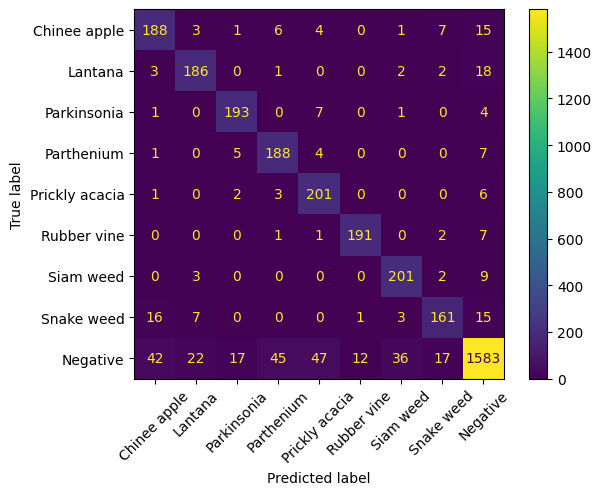

In [31]:
a, b = eval_model(model, validation_generator)

# Trial 2

Epoch 1/100


2024-03-06 00:16:18.892096: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


486/486 [==============================] - 154s 256ms/step - loss: 0.1796 - accuracy: 0.9394 - val_loss: 0.2965 - val_accuracy: 0.9038
Epoch 2/100
486/486 [==============================] - 124s 254ms/step - loss: 0.1501 - accuracy: 0.9485 - val_loss: 0.2928 - val_accuracy: 0.9078
Epoch 3/100
486/486 [==============================] - 123s 253ms/step - loss: 0.1356 - accuracy: 0.9546 - val_loss: 0.2735 - val_accuracy: 0.9178
Epoch 4/100
486/486 [==============================] - 123s 253ms/step - loss: 0.1275 - accuracy: 0.9554 - val_loss: 0.2657 - val_accuracy: 0.9106
Epoch 5/100
486/486 [==============================] - 123s 253ms/step - loss: 0.1180 - accuracy: 0.9581 - val_loss: 0.2673 - val_accuracy: 0.9086
Epoch 6/100
486/486 [==============================] - 123s 253ms/step - loss: 0.1129 - accuracy: 0.9619 - val_loss: 0.2743 - val_accuracy: 0.9061
Epoch 7/100
486/486 [==============================] - 123s 253ms/step - loss: 0.1105 - accuracy: 0.9631 - val_loss: 0.2614 - val_

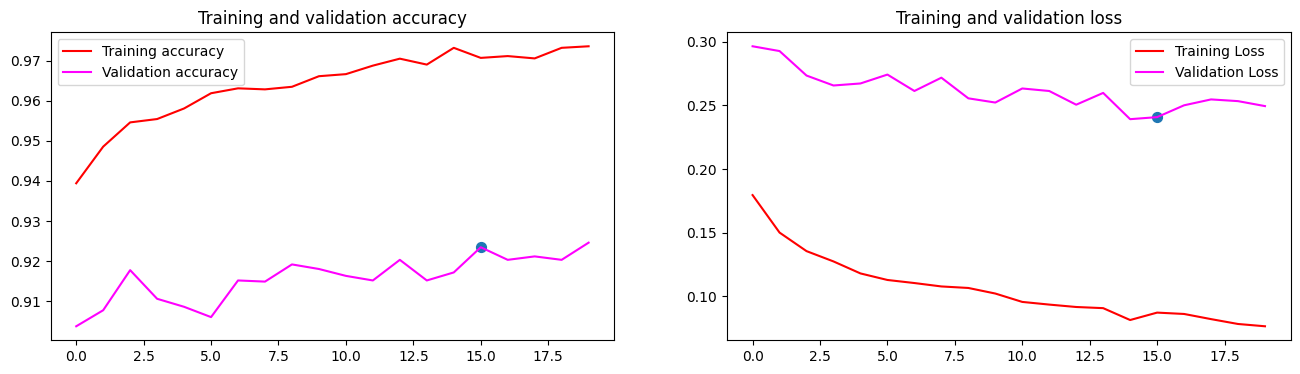

CPU times: user 39min 12s, sys: 1min 24s, total: 40min 37s
Wall time: 41min 58s


In [32]:
%%time
model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=1e-5,  weight_decay=3e-4),
          metrics=['accuracy'])

# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
    )

print("Saving the Checkpoint")
model.save("DeepWeeds-ResNet50-Model.keras")

# Plot training results
plot_loss_acc(history2.history)

model.evaluate
219/219 [==============================] - 9s 43ms/step - loss: 0.2506 - accuracy: 0.9223
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.79116   0.87556   0.83122       225
       Lantana    0.87054   0.91981   0.89450       212
   Parkinsonia    0.94340   0.97087   0.95694       206
    Parthenium    0.87215   0.93171   0.90094       205
Prickly acacia    0.87069   0.94836   0.90787       213
   Rubber vine    0.88636   0.96535   0.92417       202
     Siam weed    0.92308   0.94884   0.93578       215
    Snake weed    0.85294   0.85714   0.85504       203
      Negative    0.96920   0.91598   0.94184      1821

      accuracy                        0.92119      3502
     macro avg    0.88661   0.92596   0.90537      3502
  weighted avg    0.92425   0.92119   0.92187      3502


                False Positive Rate  Accuracy
Chinee apple               0.015868  0.875556
Lantana                    0.008815  0.919811
Parkinsonia                0.003641  0.970874
Parthenium                 0.008493  0.931707
Prickly acacia    

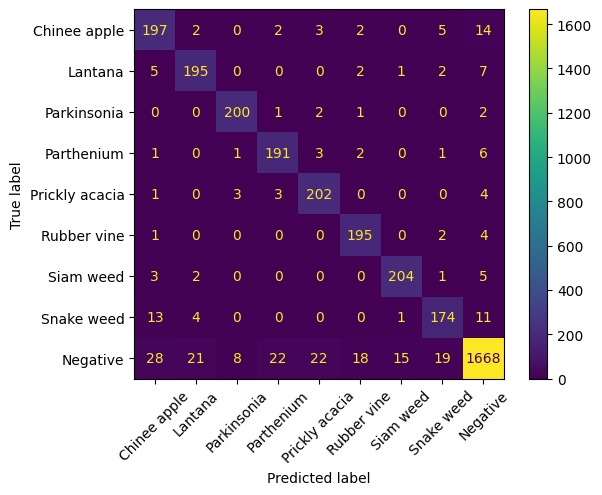

In [33]:
a, b = eval_model(model, validation_generator)

# Trial 3 - Frozen Base Model Layer

Epoch 1/100


2024-03-06 01:09:02.917310: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


486/486 [==============================] - 156s 256ms/step - loss: 0.0905 - accuracy: 0.9691 - val_loss: 0.2648 - val_accuracy: 0.9186
Epoch 2/100
486/486 [==============================] - 123s 253ms/step - loss: 0.0846 - accuracy: 0.9720 - val_loss: 0.2482 - val_accuracy: 0.9212
Epoch 3/100
486/486 [==============================] - 123s 253ms/step - loss: 0.0848 - accuracy: 0.9715 - val_loss: 0.2537 - val_accuracy: 0.9220
Epoch 4/100
486/486 [==============================] - 123s 253ms/step - loss: 0.0742 - accuracy: 0.9757 - val_loss: 0.2656 - val_accuracy: 0.9175
Epoch 5/100
486/486 [==============================] - 123s 253ms/step - loss: 0.0758 - accuracy: 0.9748 - val_loss: 0.2490 - val_accuracy: 0.9200
Epoch 6/100
486/486 [==============================] - 123s 253ms/step - loss: 0.0787 - accuracy: 0.9722 - val_loss: 0.2465 - val_accuracy: 0.9238
Epoch 7/100
486/486 [==============================] - 123s 253ms/step - loss: 0.0794 - accuracy: 0.9727 - val_loss: 0.2525 - val_

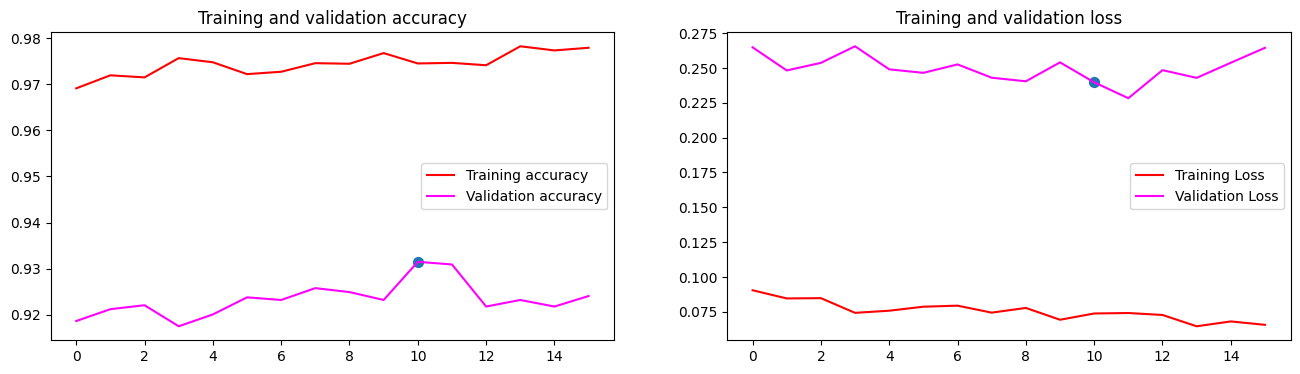

CPU times: user 31min 42s, sys: 1min 9s, total: 32min 52s
Wall time: 33min 25s


In [43]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
        
model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=5e-6,  weight_decay=1e-5),
          metrics=['accuracy'])

# Train the model
history3 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
      #class_weight=weights
    )

print("Saving the Checkpoint")
model.save("DeepWeeds-ResNet50-Model.keras")

# Plot training results
plot_loss_acc(history3.history)

model.evaluate
219/219 [==============================] - 10s 44ms/step - loss: 0.2434 - accuracy: 0.9246
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.84298   0.90667   0.87366       225
       Lantana    0.88288   0.92453   0.90323       212
   Parkinsonia    0.94737   0.96117   0.95422       206
    Parthenium    0.87097   0.92195   0.89573       205
Prickly acacia    0.84232   0.95305   0.89427       213
   Rubber vine    0.89862   0.96535   0.93079       202
     Siam weed    0.91031   0.94419   0.92694       215
    Snake weed    0.86473   0.88177   0.87317       203
      Negative    0.97100   0.91928   0.94443      1821

      accuracy                        0.92547      3502
     macro avg    0.89235   0.93088   0.91072      3502
  weighted avg    0.92831   0.92547   0.92607      3502


                False Positive Rate  Accuracy
Chinee apple               0.011596  0.906667
Lantana                    0.007903  0.924528
Parkinsonia                0.003337  0.961165
Parthenium                 0.008493  0.921951
Prickly acacia    

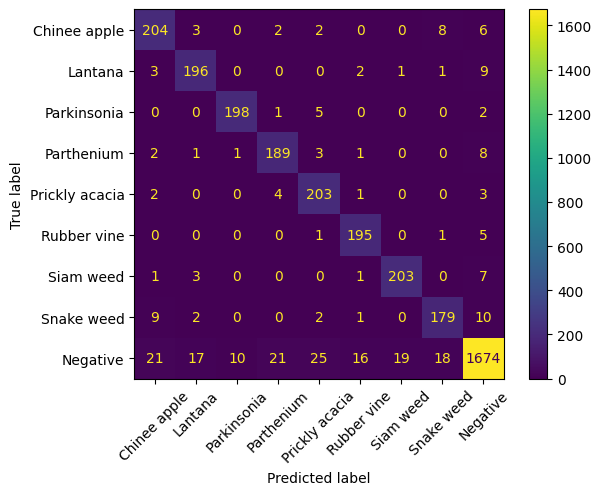

In [45]:
a, b = eval_model(model, validation_generator)

# Trail 4

Freezing layer resnet50v2
Epoch 1/100


2024-03-06 01:42:57.086725: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


486/486 [==============================] - 54s 101ms/step - loss: 0.2014 - accuracy: 0.9326 - val_loss: 0.1934 - val_accuracy: 0.9415
Epoch 2/100
486/486 [==============================] - 48s 99ms/step - loss: 0.2012 - accuracy: 0.9299 - val_loss: 0.1910 - val_accuracy: 0.9417
Epoch 3/100
486/486 [==============================] - 48s 98ms/step - loss: 0.2015 - accuracy: 0.9314 - val_loss: 0.1891 - val_accuracy: 0.9426
Epoch 4/100
486/486 [==============================] - 48s 98ms/step - loss: 0.1968 - accuracy: 0.9329 - val_loss: 0.1873 - val_accuracy: 0.9432
Epoch 5/100
486/486 [==============================] - 48s 98ms/step - loss: 0.1963 - accuracy: 0.9321 - val_loss: 0.1857 - val_accuracy: 0.9440
Epoch 6/100
486/486 [==============================] - 48s 98ms/step - loss: 0.1929 - accuracy: 0.9342 - val_loss: 0.1843 - val_accuracy: 0.9446
Epoch 7/100
486/486 [==============================] - 48s 98ms/step - loss: 0.1966 - accuracy: 0.9333 - val_loss: 0.1834 - val_accuracy: 0.9

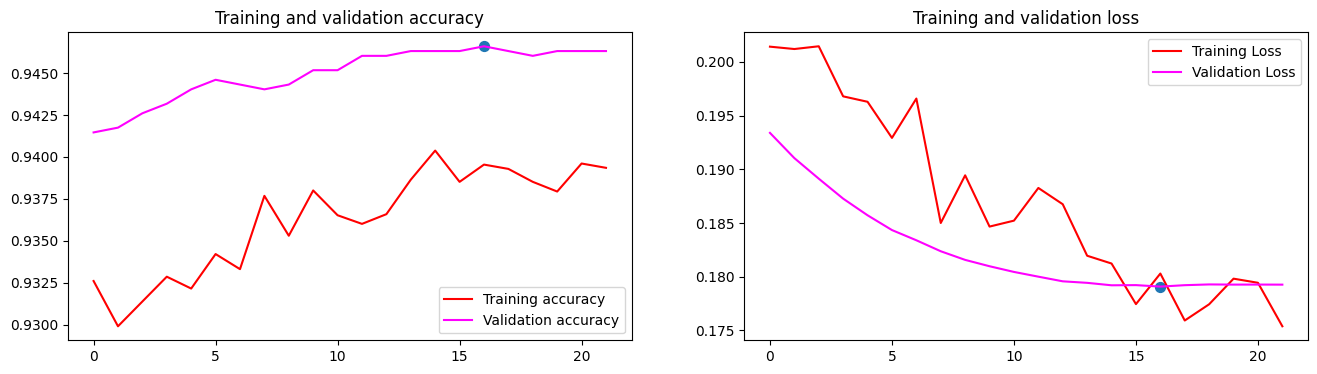

CPU times: user 16min 29s, sys: 1min 29s, total: 17min 58s
Wall time: 17min 41s


In [46]:
%%time
for layer in model.layers:
    if layer.name == 'resnet50v2':
        print("Freezing layer", layer.name)
        layer.trainable = False
        
model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=1e-6,  weight_decay=1e-6),
          metrics=['accuracy'])

# Train the model
history4 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
      #class_weight=weights
    )

print("Saving the Checkpoint")
model.save("DeepWeeds-ResNet50-Model.keras")

# Plot training results
plot_loss_acc(history4.history)

model.evaluate
219/219 [==============================] - 9s 41ms/step - loss: 0.1791 - accuracy: 0.9466
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.90135   0.89333   0.89732       225
       Lantana    0.93810   0.92925   0.93365       212
   Parkinsonia    0.95714   0.97573   0.96635       206
    Parthenium    0.88393   0.96585   0.92308       205
Prickly acacia    0.90043   0.97653   0.93694       213
   Rubber vine    0.91284   0.98515   0.94762       202
     Siam weed    0.93333   0.97674   0.95455       215
    Snake weed    0.88679   0.92611   0.90602       203
      Negative    0.97942   0.94069   0.95966      1821

      accuracy                        0.94660      3502
     macro avg    0.92148   0.95215   0.93613      3502
  weighted avg    0.94816   0.94660   0.94683      3502


                False Positive Rate  Accuracy
Chinee apple               0.006713  0.893333
Lantana                    0.003951  0.929245
Parkinsonia                0.002731  0.975728
Parthenium                 0.007886  0.965854
Prickly acacia    

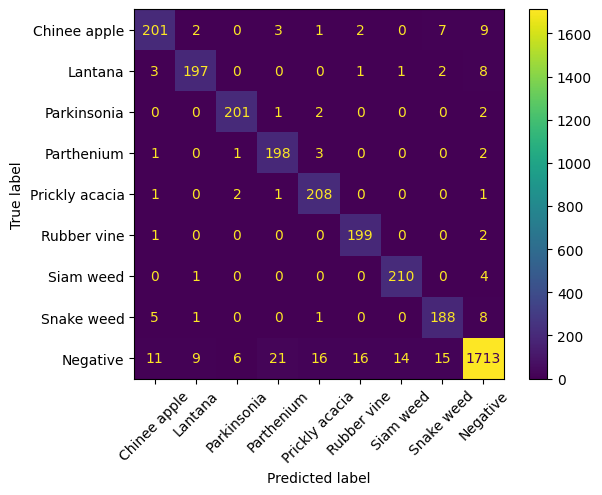

In [47]:
a, b = eval_model(model, validation_generator)

# Trial 5

Class Weights:  {0: 0.89, 1: 0.89, 2: 0.89, 3: 0.89, 4: 0.89, 5: 0.89, 6: 0.89, 7: 0.89, 8: 1.11}
Epoch 1/100


2024-03-06 02:13:18.878647: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


486/486 [==============================] - 54s 101ms/step - loss: 0.1736 - accuracy: 0.9389 - val_loss: 0.1784 - val_accuracy: 0.9466
Epoch 2/100
486/486 [==============================] - 48s 98ms/step - loss: 0.1708 - accuracy: 0.9377 - val_loss: 0.1778 - val_accuracy: 0.9463
Epoch 3/100
486/486 [==============================] - 48s 98ms/step - loss: 0.1720 - accuracy: 0.9406 - val_loss: 0.1775 - val_accuracy: 0.9463
Epoch 4/100
486/486 [==============================] - 48s 98ms/step - loss: 0.1679 - accuracy: 0.9402 - val_loss: 0.1771 - val_accuracy: 0.9463
Epoch 5/100
486/486 [==============================] - 48s 99ms/step - loss: 0.1748 - accuracy: 0.9384 - val_loss: 0.1768 - val_accuracy: 0.9466
Epoch 6/100
486/486 [==============================] - 48s 99ms/step - loss: 0.1708 - accuracy: 0.9380 - val_loss: 0.1767 - val_accuracy: 0.9466
Epoch 6: early stopping
Saving the Checkpoint
Total Epochs: 6


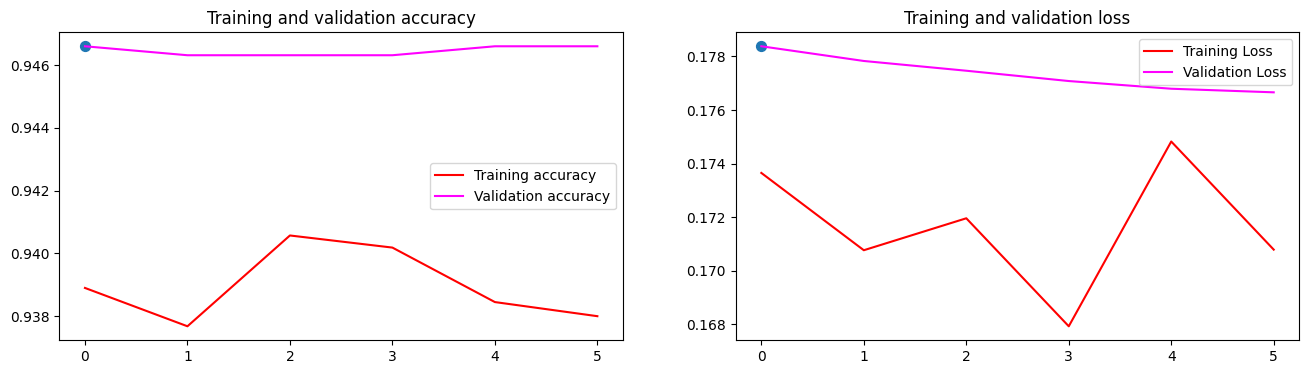

model.evaluate
219/219 [==============================] - 9s 41ms/step - loss: 0.1784 - accuracy: 0.9466
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.90950   0.89333   0.90135       225
       Lantana    0.94258   0.92925   0.93587       212
   Parkinsonia    0.95694   0.97087   0.96386       206
    Parthenium    0.87946   0.96098   0.91841       205
Prickly acacia    0.90043   0.97653   0.93694       213
   Rubber vine    0.91284   0.98515   0.94762       202
     Siam weed    0.93333   0.97674   0.95455       215
    Snake weed    0.88679   0.92611   0.90602       203
      Negative    0.97832   0.94179   0.95971      1821

      accuracy                        0.94660      3502
     macro avg    0.92225   0.95119   0.93604      3502
  weighted avg    0.94811   0.94660   0.94683      3502


                False Positive Rate  Accuracy
Chinee apple               0.006103  0.893333
Lantana                    0.003647  0.929245
Parkinsonia                0.002731  0.970874
Parthenium                 0.008189  0.960976
Prickly acacia    

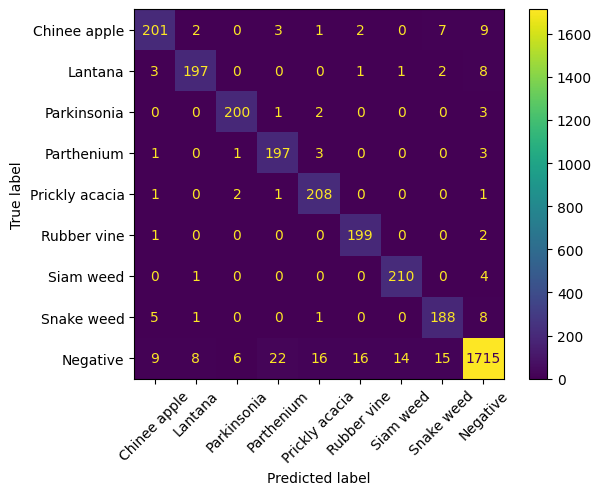

In [55]:
model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=1e-6,  weight_decay=1e-7),
          metrics=['accuracy'])

weights = {0:0.89,1:0.89,2:0.89,3:0.89,4:0.89,5:0.89,6:0.89,7:0.89,8:1.11}
print("Class Weights: ",weights)

# Train the model
history5 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
      class_weight=weights
    )

print("Saving the Checkpoint")
model.save("DeepWeeds-ResNet50-Model.keras")

# Plot training results
plot_loss_acc(history5.history)
a, b = eval_model(model, validation_generator)

# Evaluations

Total Epochs: 85


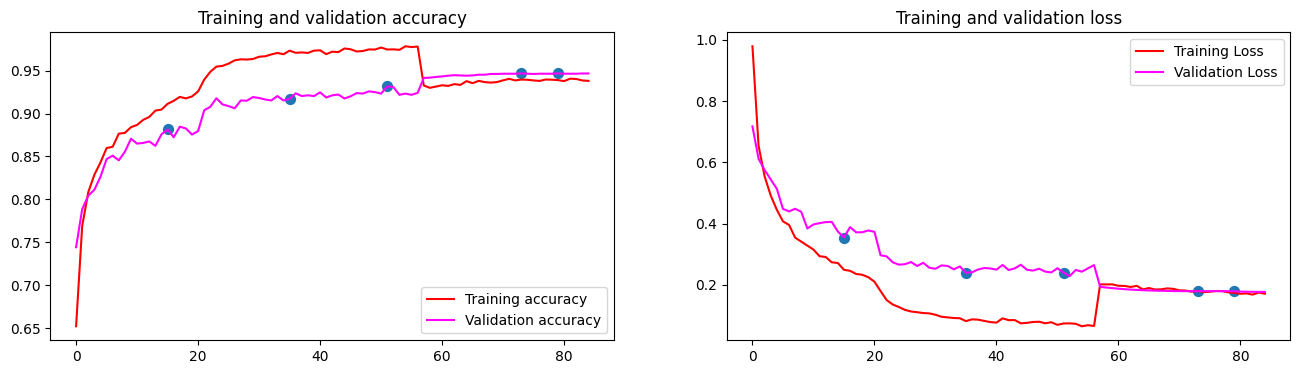

In [57]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])
    history[key].extend(history3.history[key])
    history[key].extend(history4.history[key])
    history[key].extend(history5.history[key])
    

h1len = len(history1.history['accuracy'])  
h2len = len(history2.history['accuracy'])
h3len = len(history3.history['accuracy'])
h4len = len(history4.history['accuracy'])
h5len = len(history5.history['accuracy'])
history['peaks'] = [h1len-6, (h1len+h2len)-6, (h1len+h2len+h3len)-6, 
                    (h1len+h2len+h3len+h4len)-6, (h1len+h2len+h3len+h4len+h5len)-6]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

In [58]:
## Computing Positive Threshold Using Validation Dataset
thresholds = []
for i in range(len(a)):
    n_label = prediction_argmax(b[i])
    ap_label = np.argmax(b[i])
    a_label = a[i]

    if(n_label == a_label):
        thresholds.append(b[n_label])


rand_guess = np.mean(thresholds)
"Threshold = {}".format(rand_guess)

'Threshold = 0.1111111119389534'

## Normal Evaluation

Normal Evaluation   
--------------------------------------------------------------------
model.evaluate
219/219 [==============================] - 9s 41ms/step - loss: 0.1786 - accuracy: 0.9474
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.88511   0.92444   0.90435       225
       Lantana    0.93868   0.93427   0.93647       213
   Parkinsonia    0.92727   0.99029   0.95775       206
    Parthenium    0.88739   0.96569   0.92488       204
Prickly acacia    0.91781   0.94811   0.93271       212
   Rubber vine    0.91981   0.96535   0.94203       202
     Siam weed    0.93333   0.97674   0.95455       215
    Snake weed    0.90099   0.89655   0.89877       203
      Negative    0.98119   0.94509   0.96280      1821

      accuracy                        0.94744      3501
     macro avg    0.92129   0.94962   0.93492      3501
  weighted avg    0.94882   0.94744   0.94769      3501


                False Positive Rate  Accuracy
Chinee apple               0.008242  0.924444
Lantana                    0.003954  0.934272
Parkinsonia                0.004856  0.990291
Parthenium                 0.007583  0.965686
Prickly acacia    

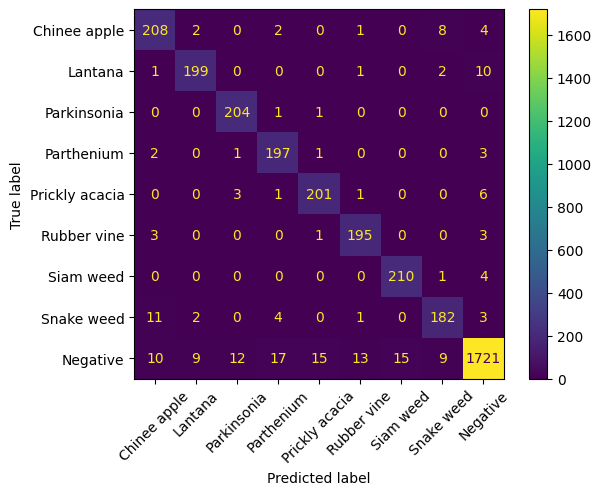

In [59]:
print("Normal Evaluation \
  \n--------------------------------------------------------------------")
a, b = eval_model(model, test_generator)

## Random Guess Threshold
> As applied by the paper DeepWeeds

Evaluation with Random Guess - As applied by the paper DeepWeeds   
--------------------------------------------------------------------
Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.83333   0.93333   0.88050       225
       Lantana    0.88745   0.96244   0.92342       213
   Parkinsonia    0.92727   0.99029   0.95775       206
    Parthenium    0.89091   0.96078   0.92453       204
Prickly acacia    0.85714   0.96226   0.90667       212
   Rubber vine    0.91549   0.96535   0.93976       202
     Siam weed    0.92920   0.97674   0.95238       215
    Snake weed    0.90099   0.89655   0.89877       203
      Negative    0.98764   0.92147   0.95341      1821

      accuracy                        0.93802      3501
     macro avg    0.90327   0.95214   0.92635      3501
  weighted avg    0.94176   0.93802   0.93862      3501


                False Positive Rate  Accuracy
Chinee apple               0.012821  0.933333
Lantana            

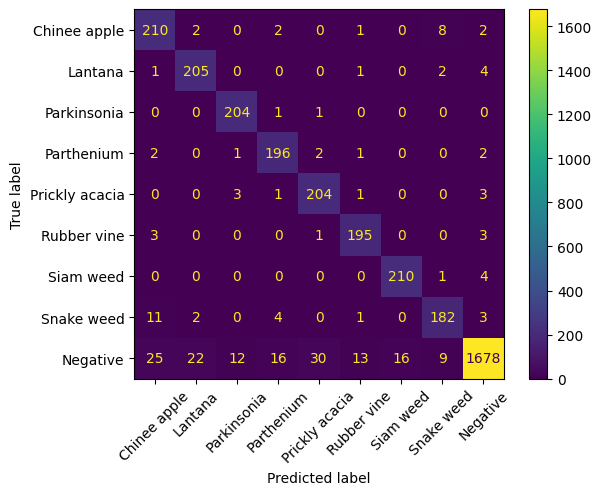

In [60]:
print("Evaluation with Random Guess - As applied by the paper DeepWeeds \
  \n--------------------------------------------------------------------")
printStats(a,b,rand_guess)

In [61]:
shutil.rmtree(base_dir)